 ### An improved model prediction for the "bank telemarketing" dataset
##### Author: Marlon Ferrari

### Abstract
<p> The purpose of this work is to build a better model when compared with the presented under the research <a href='http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf'>"A data-driven approach to predict the success of bank telemarketing"</a> </p>
<p> Using a multi-CART stacking strategy, K-Fold method and Randomized Hyperparameters search, the final performance model was according to the expected research measures and above.  

### Related Measure 

The related research used as guide for this work, showed up 4 models and its related AUC final measure:

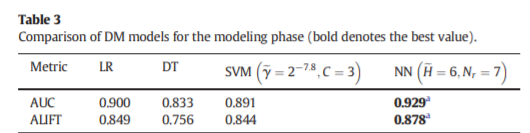

And the final results of this work suggests an improvement, which could be better exploited under other kernels:
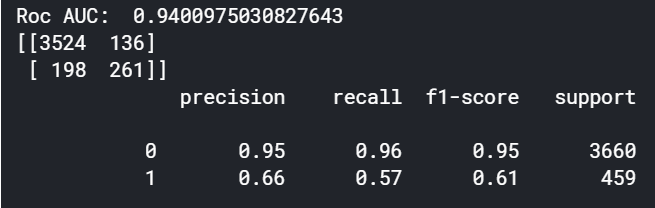

In [ ]:
#a great tool for Pandas Pipelines
!pip install pdpipe

In [ ]:
#ferramentas basicas
import pandas as pd
pd.set_option('display.max_colwidth', 500)

#https://medium.com/analytics-vidhya/is-pipeline-important-in-machine-learning-pipeline-with-pdpipe-b6fc9acf20c4
import pdpipe as pdp

import numpy as np
import matplotlib.pyplot as plt

#feature engineering
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
#CART models 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#validação
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

dataset = pd.read_csv('../input/bank-marketing/bank-additional-full.csv', sep=';')

In [ ]:
dataset.y.value_counts()

### DATASET SPLITTING
There are two ways about splitting: with/without validation
Since this Kaggle Dataset has not a submission, I think it important to simulate one, but the choice is yours.


Numpy splits is cool because it does not divides the dataset (i.e, breaks X,y). This is important when is needed to apply data transformations.

In [ ]:
#TRAIN-VAL-TEST
#                                                                 GETS 80%           GETS 10%  GETS 10%
train, validate, test = np.split(dataset.sample(frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])

#TRAIN-TEST
#test, train = np.split(dataset.sample(frac=1), [int(.2*len(dataset))])

In [ ]:
print(train.shape)
print(test.shape)
print(validate.shape)

In [ ]:
train.y.value_counts()

The next code enables to suppress "unknown" values by imputing the most frequent (mode) from the columns. Feel free to use, but under my analysis, it didn't make difference.

In [ ]:
'''
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = 'unknown', strategy = 'most_frequent').fit(train)
train = pd.DataFrame(imputer.transform(train), columns=list(dataset.columns))
test = pd.DataFrame(imputer.transform(test), columns=list(dataset.columns))
validate = pd.DataFrame(imputer.transform(validate), columns=list(dataset.columns))
'''

The next code is for balance the predicted classes 'yes' and 'no'. Under my experiments, it didn't performed better, and I had a better performance measure (F1 for class 1 and model AUC-ROC) without it.

In [ ]:
'''
#DATASET DE TREINO DESBALANCEADO

#METODO MINORITARIO
from sklearn.utils import resample

df_marjority = train[train.y=='no']
df_minority = train[train.y=='yes']
 
# Upsample minority class
df_marjority_sampled = resample(df_marjority, 
                                 replace=True,     # sample with replacement
                                 # classe maioritaria aumentada em 50%
                                 n_samples=int(df_minority.shape[0]*0.9),    # to match minority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
train = pd.concat([df_minority, df_marjority_sampled])
 
# Display new class counts
train.y.value_counts()
'''

In [ ]:
train.head(2)

### Data Pipeline
PdPipe has a great advantage against sklearn Pipelines: it keeps a Pandas DF, not a numpy Dense Matrix. I didn't evaluated performance and had not previous experience with it, just fitted in my needs.

In [ ]:
#drops the column DEFAULT (it has no relevance)
drop_default =  pdp.ColDrop('default')

hot_encode = pdp.OneHotEncode(['job', 'marital', 'education','housing','loan','contact'])

map_y = pdp.MapColVals('y',{'yes':1,'no':0})
map_month = pdp.MapColVals('month',{'jan':1,'feb':2,'mar':3,'apr':4,
                        'may':5,'jun':6,'jul':7,'aug':8,
                        'sep':9,'oct':10,'nov':11,'dec':12})
map_days = pdp.MapColVals('day_of_week',{'mon':2,'tue':3,'wed':4,'thu':5,'fri':6,'sat':7,'sun':1})
map_poutcome = pdp.MapColVals('poutcome',{'nonexistent':0,'failure':1,'success':2})

#builds the tranformation worflow
pipeline = pdp.make_pdpipeline(drop_default, hot_encode,map_y,map_month, map_days, map_poutcome)

df_train=pipeline(train)
X_train = df_train.drop('y', axis=1)
y_train = df_train[['y']]

In [ ]:
X_train.head()

### Feature Selection

In [ ]:
rf_selection = RandomForestClassifier(random_state = 42)

folds = 3
param_comb = 5

skf = KFold(n_splits=folds, shuffle = True, random_state = 42)

param_search = { 
    'n_estimators': [500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}

random_search_selection = RandomizedSearchCV(rf_selection, param_distributions=param_search, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf, verbose=3, random_state=42)
random_search_selection.fit(X_train, y_train)

In [ ]:
clf = random_search_selection.best_estimator_
selector = clf.fit(X_train, y_train)

In [ ]:
#pipeline for test dataset using previous PDPIPE worflow
df_test=pipeline(test)
X_test = df_test.drop('y', axis=1)
y_test = df_test[['y']]

In [ ]:
#apply the feature selector to both datasets
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

### Main Model - XGBoost

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        
}

xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = KFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf, verbose=3, random_state=42 )

random_search.fit(X_train, y_train)

In [ ]:
#selects the best model
xgb_model = random_search.best_estimator_

xgboost_yhat = xgb_model.predict(X_test)
# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1],
              average='macro'))

print(confusion_matrix(y_test,xgboost_yhat))
print(classification_report(y_test,xgboost_yhat))

### VALIDATION (Submission Simulator)

In [ ]:
df_val=pipeline(validate)
X_val = df_val.drop('y', axis=1)
y_val = df_val[['y']]

In [ ]:
X_val = fs.transform(X_val)

In [ ]:
xgboost_yhat = xgb_model.predict(X_val)
print("Roc AUC: ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1],
              average='macro'))
print(confusion_matrix(y_val,xgboost_yhat))
print(classification_report(y_val,xgboost_yhat))